The goal of this notebook is to construct linear state observers based on the models generated by each model reduction method

In [53]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-
import numpy as np
from sklearn.decomposition import TruncatedSVD
from scipy.sparse import csr_matrix
from sklearn.utils.extmath import randomized_svd
from prettytable import PrettyTable
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import matplotlib as mpl
from matplotlib.animation import FuncAnimation
from dotenv import dotenv_values 
from moviepy.editor import VideoClip
from moviepy.video.io.bindings import mplfig_to_npimage
import scipy.io
import pyvista as pv
import h5py
import mat73
from scipy import signal
import control
import dask.array as da
from dask.distributed import Client, LocalCluster


import opinf


config = dotenv_values(".env")
from util import *

In [54]:
# Setup Dask client
# cluster = LocalCluster() # Launches a scheduler and workers locally
# client = Client(cluster) # Connect to distributed cluster and override default
client = Client('tcp://127.0.0.1:8786')
client.cluster

In [55]:
# Setup filepaths for reading data 
filepath = config["currentDirectory"] + "data/archivedDataSets/FullAssembly_Constrained_FullSetForICRA/"
# Read in system and gain matrices from .mat file
systemMats = scipy.io.loadmat(filepath + "romSystemMatricesAndGains_22dim_3train_2test.mat")
# ERA matrices
A_era = systemMats["A_era"]
B_era = systemMats["B_era"]
C_era = systemMats["C_era"]
D_era = systemMats["D_era"]
L_era = systemMats["L_era"]
# DMDc Matrices
A_dmdc = systemMats["A_dmdc"]
B_dmdc = systemMats["B_dmdc"]
C_dmdc = systemMats["C_dmdc"]
L_dmdc = systemMats["L_dmdc"]
# LOpInf Matrices
A_lopInf = systemMats["A_lopinf"]
B_lopInf = systemMats["B_lopinf"]
C_lopInf = systemMats["C_lopinf"]
D_lopInf = systemMats["D_lopinf"]
L_lopInf = systemMats["L_lopinf"]

# Read in offset vector
x0 = systemMats["x0"]

In [56]:
n_train = 3
n_test = 7

In [57]:
systemMats.keys()

dict_keys(['__header__', '__version__', '__globals__', 'A_dmdc', 'A_era', 'A_lopinf', 'B_dmdc', 'B_era', 'B_lopinf', 'C_dmdc', 'C_era', 'C_lopinf', 'D_era', 'D_lopinf', 'L_dmdc', 'L_era', 'L_lopinf', 'basis_dmdc', 'basis_lopinf', 'poles', 'x0', 'y0'])

In [58]:
# Read in basis transformations for methods that enable state reconstruction
# lopinfOperators = scipy.io.loadmat(filepath + "lopinf_rom_r_6_operators.mat")
basis_dmdc = systemMats["basis_dmdc"]
basis_lopinf = systemMats["basis_lopinf"]
# Pad the lopinf basis with columns of 0s so that it has 12 columns
basis_lopinf = np.hstack((basis_lopinf, np.zeros((basis_lopinf.shape[0], basis_lopinf.shape[1]))))
# Convert to dask arrays
basis_dmdc = da.from_array(basis_dmdc, chunks=(4096, basis_dmdc.shape[1]))
basis_lopinf = da.from_array(basis_lopinf, chunks=(4096, basis_lopinf.shape[1]))



In [59]:
# Get dimension of output space of basis functions
basis_lopinf.shape[0]

231336

# Observer Comparison Experiments

In [60]:
# Load in data
data = h5py.File(filepath+ "fullDataSet.hdf5", 'r')
# Read in a trial
trial = 0
# Read in the data for the specific trial
X_fom = da.from_array(data["stateData"], chunks=(4096, 4096,1))
U_fom = data["inputData"]
Y_fom = data["reducedCenterlineData"][:,:,:]
x0 = data["stateData"][:,0,0]
Y0 = data["reducedCenterlineData"][:,0,0]

# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

timesteps = Y_fom.shape[1]
# Save state data to so we can memmap it later
# np.save(filepath + "temp/stateData.npy", data["stateData"])
# Extract simulation parameters
numTrials = data["reducedCenterlineData"].shape[2]



In [61]:
# # Initialize observer state and output for each ROM method
# # ERA
# x_hat_era = np.zeros((A_era.shape[0], timesteps)) # Closed loop era observer
# x_hat_ol_era = np.zeros((A_era.shape[0], timesteps)) # Open loop era observer
# y_hat_era = np.zeros((C_era.shape[0], timesteps)) # Closed loop era observer
# y_hat_ol_era = np.zeros((C_era.shape[0], timesteps)) # Open loop era observer
# # DMDc
# x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
# x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps)) # Open loop dmdc observer
# y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Closed loop dmdc observer
# y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps)) # Open loop dmdc observer
# # LOpinf
# x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
# x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps)) # Open loop lopinf observer
# y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Closed loop lopinf observer
# y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps)) # Open loop lopinf observer



# # Iterate through each timestep applying observer update law
# for i in range(timesteps-1):
#     # Update observer states
#     x_hat_era[:,i+1] = A_era @ x_hat_era[:,i] +B_era@U_fom[:,i] - L_era @ (y_hat_era[:,i] - Y_fom[:,i]) # Closed loop era observer
#     x_hat_ol_era[:,i+1] = A_era @ x_hat_ol_era[:,i] +B_era@U_fom[:,i] # Open loop era observer
#     x_hat_dmdc[:,i+1] = A_dmdc @ x_hat_dmdc[:,i] +B_dmdc@U_fom[:,i] - L_dmdc @ (y_hat_dmdc[:,i] - Y_fom[:,i]) # Closed loop dmdc observer
#     x_hat_ol_dmdc[:,i+1] = A_dmdc @ x_hat_ol_dmdc[:,i] +B_dmdc@U_fom[:,i] # Open loop dmdc observer
#     x_hat_lopInf[:,i+1] = A_lopInf @ x_hat_lopInf[:,i] +B_lopInf@U_fom[:,i] - L_lopInf @ (y_hat_lopInf[:,i] - Y_fom[:,i]) # Closed loop lopinf observer
#     x_hat_ol_lopInf[:,i+1] = A_lopInf @ x_hat_ol_lopInf[:,i] +B_lopInf@U_fom[:,i] # Open loop lopinf observer


#     # Update observer output
#     y_hat_era[:,i+1] = C_era @ x_hat_era[:,i+1] + D_era @ U_fom[:,i] # Closed loop era observer
#     y_hat_ol_era[:,i+1] = C_era @ x_hat_ol_era[:,i+1] + D_era @ U_fom[:,i] # Open loop era observer
#     y_hat_dmdc[:,i+1] = C_dmdc @ x_hat_dmdc[:,i+1]  # Closed loop dmdc observer
#     y_hat_ol_dmdc[:,i+1] = C_dmdc @ x_hat_ol_dmdc[:,i+1]  # Open loop dmdc observer
#     y_hat_lopInf[:,i+1] = C_lopInf @ x_hat_lopInf[:,i+1] # Closed loop lopinf observer
#     y_hat_ol_lopInf[:,i+1] = C_lopInf @ x_hat_ol_lopInf[:,i+1] # Open loop lopinf observer
    




In [62]:
# # plot first output from observer against ground truth with open loop responses in dashed lines and closed loop responses in solid lines
# plt.plot(Y_fom[0,:], label="Ground Truth", color="black", linewidth=10)
# plt.plot(y_hat_ol_era[0,:], "--", label="ERA Open Loop", color="red", linewidth=3)
# plt.plot(y_hat_era[0,:], label="ERA Closed Loop", color="red", linewidth=3)
# plt.plot(y_hat_ol_dmdc[0,:], "--", label="DMDc Open Loop", color="blue", linewidth=3)
# plt.plot(y_hat_dmdc[0,:], label="DMDc Closed Loop", color="blue", linewidth=3)
# plt.plot(y_hat_ol_lopInf[0,:], "--", label="LOpInf Open Loop", color="magenta", linewidth=3)
# plt.plot(y_hat_lopInf[0,:], label="LOpInf Closed Loop", color="magenta", linewidth=3)
# plt.xlabel("Timestep")
# plt.ylabel("Output")
# plt.title("Output 0")
# plt.xlim([0, 200])
# plt.ylim([-8, 5])
# plt.xticks([0, 100, 200])
# plt.yticks([-8, 0, 4])

# plt.legend()
# # plt.show()
# # Save as svg
# plt.savefig("output0Trial1.pdf", format="pdf")


In [63]:
# Generate open and closed loop responses for each observer for every trial
# Initialize arrays to store data
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, numTrials)) # Closed loop era observer
x_hat_ol_era = np.zeros((A_era.shape[0], timesteps, numTrials)) # Open loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, numTrials)) # Closed loop era observer
y_hat_ol_era = np.zeros((C_era.shape[0], timesteps, numTrials)) # Open loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, numTrials)) # Closed loop dmdc observer
x_hat_ol_dmdc = np.zeros((A_dmdc.shape[0], timesteps, numTrials)) # Open loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, numTrials)) # Closed loop dmdc observer
y_hat_ol_dmdc = np.zeros((C_dmdc.shape[0], timesteps, numTrials)) # Open loop dmdc observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, numTrials)) # Closed loop lopinf observer
x_hat_ol_lopInf = np.zeros((A_lopInf.shape[0], timesteps, numTrials)) # Open loop lopinf observer  
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, numTrials)) # Closed loop lopinf observer
y_hat_ol_lopInf = np.zeros((C_lopInf.shape[0], timesteps, numTrials)) # Open loop lopinf observer

# Iterate through each trial
for trial in range(numTrials):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] - L_era @ (y_hat_era[:,i,trial] - Y_fom[:,i,trial]) # Closed loop era observer
        x_hat_ol_era[:,i+1,trial] = A_era @ x_hat_ol_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] - L_dmdc @ (y_hat_dmdc[:,i,trial] - Y_fom[:,i,trial]) # Closed loop dmdc observer
        x_hat_ol_dmdc[:,i+1,trial] = A_dmdc @ x_hat_ol_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] - L_lopInf @ (y_hat_lopInf[:,i,trial] - Y_fom[:,i,trial]) # Closed loop lopinf observer
        x_hat_ol_lopInf[:,i+1,trial] = A_lopInf @ x_hat_ol_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_ol_era[:,i+1,trial] = C_era @ x_hat_ol_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Open loop era observer
        y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        y_hat_ol_dmdc[:,i+1,trial] = C_dmdc @ x_hat_ol_dmdc[:,i+1,trial]  # Open loop dmdc observer
        y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        y_hat_ol_lopInf[:,i+1,trial] = C_lopInf @ x_hat_ol_lopInf[:,i+1,trial] # Open loop lopinf observer
        

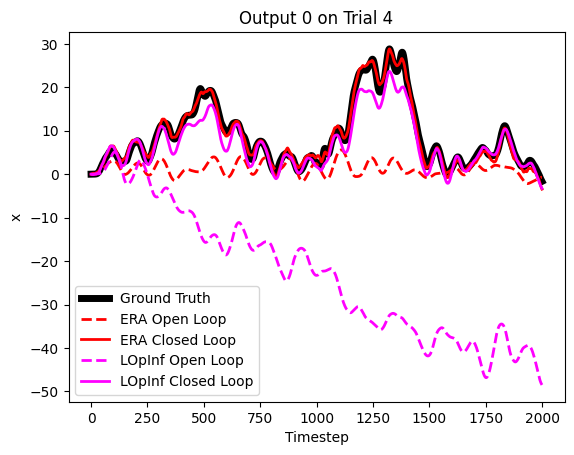

In [64]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black

trial = 4
fig, ax = plt.subplots()


# plt.figure()
ax.plot(Y_fom[0,:,trial], label="Ground Truth", color="black", linewidth=5)
ax.plot(y_hat_ol_era[0,:,trial], "--", label="ERA Open Loop", color="red", linewidth=2)
ax.plot(y_hat_era[0,:,trial], label="ERA Closed Loop", color="red", linewidth=2)
# ax.plot(y_hat_ol_dmdc[0,:,trial], "--", label="DMDc Open Loop", color="blue", linewidth=5)
# ax.plot(y_hat_dmdc[0,:,trial], label="DMDc Closed Loop", color="blue", linewidth=5)
# plt.plot(y_hat_ol_opInf[0,:,trial], "--", label="OpInf Open Loop", color="green", linewidth=5)
# plt.plot(y_hat_opInf[0,:,trial], label="OpInf Closed Loop", color="green", linewidth=5)
ax.plot(y_hat_ol_lopInf[0,:,trial], "--", label="LOpInf Open Loop", color="magenta", linewidth=2)
ax.plot(y_hat_lopInf[0,:,trial], label="LOpInf Closed Loop", color="magenta", linewidth=2)
ax.set_xlabel("Timestep")
ax.set_ylabel("x")
ax.set_title("Output 0 on Trial " + str(trial))
ax.legend()
# Save as svg
# plt.savefig("output0_trial" + str(trial) + ".pdf", format="pdf")

In [65]:
# Convert everything to dask arrays
# A_era = da.from_array(A_era, chunks=(A_era.shape[0], A_era.shape[1]))
# B_era = da.from_array(B_era, chunks=(B_era.shape[0], B_era.shape[1]))
# C_era = da.from_array(C_era, chunks=(C_era.shape[0], C_era.shape[1]))
# D_era = da.from_array(D_era, chunks=(D_era.shape[0], D_era.shape[1]))
# L_era = da.from_array(L_era, chunks=(L_era.shape[0], L_era.shape[1]))
# A_dmdc = da.from_array(A_dmdc, chunks=(A_dmdc.shape[0], A_dmdc.shape[1]))
# B_dmdc = da.from_array(B_dmdc, chunks=(B_dmdc.shape[0], B_dmdc.shape[1]))
# C_dmdc = da.from_array(C_dmdc, chunks=(C_dmdc.shape[0], C_dmdc.shape[1]))
# L_dmdc = da.from_array(L_dmdc, chunks=(L_dmdc.shape[0], L_dmdc.shape[1]))
# A_lopInf = da.from_array(A_lopInf, chunks=(A_lopInf.shape[0], A_lopInf.shape[1]))
# B_lopInf = da.from_array(B_lopInf, chunks=(B_lopInf.shape[0], B_lopInf.shape[1]))
# C_lopInf = da.from_array(C_lopInf, chunks=(C_lopInf.shape[0], C_lopInf.shape[1]))
# D_lopInf = da.from_array(D_lopInf, chunks=(D_lopInf.shape[0], D_lopInf.shape[1]))
# L_lopInf = da.from_array(L_lopInf, chunks=(L_lopInf.shape[0], L_lopInf.shape[1]))
x0 = da.from_array(x0, chunks=4096)
Y_fom = da.from_array(Y_fom, chunks=4096)
U_fom = da.from_array(U_fom, chunks=4096)

# Convert all rom state arrays to dask arrays
x_hat_era = da.from_array(x_hat_era, chunks=(x_hat_era.shape[0], x_hat_era.shape[1], x_hat_era.shape[2]))
x_hat_ol_era = da.from_array(x_hat_ol_era, chunks=(x_hat_ol_era.shape[0], x_hat_ol_era.shape[1], x_hat_ol_era.shape[2]))
y_hat_era = da.from_array(y_hat_era, chunks=(y_hat_era.shape[0], y_hat_era.shape[1], y_hat_era.shape[2]))
y_hat_ol_era = da.from_array(y_hat_ol_era, chunks=(y_hat_ol_era.shape[0], y_hat_ol_era.shape[1], y_hat_ol_era.shape[2]))
x_hat_dmdc = da.from_array(x_hat_dmdc, chunks=(x_hat_dmdc.shape[0], x_hat_dmdc.shape[1], x_hat_dmdc.shape[2]))
x_hat_ol_dmdc = da.from_array(x_hat_ol_dmdc, chunks=(x_hat_ol_dmdc.shape[0], x_hat_ol_dmdc.shape[1], x_hat_ol_dmdc.shape[2]))
y_hat_dmdc = da.from_array(y_hat_dmdc, chunks=(y_hat_dmdc.shape[0], y_hat_dmdc.shape[1], y_hat_dmdc.shape[2]))
y_hat_ol_dmdc = da.from_array(y_hat_ol_dmdc, chunks=(y_hat_ol_dmdc.shape[0], y_hat_ol_dmdc.shape[1], y_hat_ol_dmdc.shape[2]))
x_hat_lopInf = da.from_array(x_hat_lopInf, chunks=(x_hat_lopInf.shape[0], x_hat_lopInf.shape[1], x_hat_lopInf.shape[2]))
x_hat_ol_lopInf = da.from_array(x_hat_ol_lopInf, chunks=(x_hat_ol_lopInf.shape[0], x_hat_ol_lopInf.shape[1], x_hat_ol_lopInf.shape[2]))
y_hat_lopInf = da.from_array(y_hat_lopInf, chunks=(y_hat_lopInf.shape[0], y_hat_lopInf.shape[1], y_hat_lopInf.shape[2]))
y_hat_ol_lopInf = da.from_array(y_hat_ol_lopInf, chunks=(y_hat_ol_lopInf.shape[0], y_hat_ol_lopInf.shape[1], y_hat_ol_lopInf.shape[2]))



In [66]:
# Compute open and closed loop RRMS output errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = da.zeros((2, numTrials)) # ERA
rms_dmdc = da.zeros((2, numTrials)) # DMDc
rms_lopInf = da.zeros((2, numTrials)) # LOpInf
# Iterate through each trial
for trial in range(numTrials):
    # Compute open loop RMS error
    rms_era[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_era[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_dmdc[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_dmdc[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_lopInf[0,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_ol_lopInf[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    # Compute closed loop RMS error
    rms_era[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_era[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_dmdc[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_dmdc[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))
    rms_lopInf[1,trial] = da.sqrt(da.mean(da.square(Y_fom[:,:,trial] - y_hat_lopInf[:,:,trial]))/da.linalg.norm(Y_fom[:,:,trial], ord='fro'))


In [67]:
# Execute dask arrays
rms_era, rms_dmdc, rms_lopInf = da.compute(rms_era, rms_dmdc, rms_lopInf)


In [68]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["ERA Open Loop", str(np.mean(rms_era[0,:])) + " +/- " + str(np.std(rms_era[0,:])), str(np.max(rms_era[0,:])) + " in trial " + str(np.argmax(rms_era[0,:])), str(np.min(rms_era[0,:])) + " in trial " + str(np.argmin(rms_era[0,:]))])
rms_table.add_row(["ERA Closed Loop", str(np.mean(rms_era[1,:])) + " +/- " + str(np.std(rms_era[1,:])), str(np.max(rms_era[1,:])) + " in trial " + str(np.argmax(rms_era[1,:])), str(np.min(rms_era[1,:])) + " in trial " + str(np.argmin(rms_era[1,:]))])
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc[0,:])) + " +/- " + str(np.std(rms_dmdc[0,:])), str(np.max(rms_dmdc[0,:])) + " in trial " + str(np.argmax(rms_dmdc[0,:])), str(np.min(rms_dmdc[0,:])) + " in trial " + str(np.argmin(rms_dmdc[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc[1,:])) + " +/- " + str(np.std(rms_dmdc[1,:])), str(np.max(rms_dmdc[1,:])) + " in trial " + str(np.argmax(rms_dmdc[1,:])), str(np.min(rms_dmdc[1,:])) + " in trial " + str(np.argmin(rms_dmdc[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf[0,:])) + " +/- " + str(np.std(rms_lopInf[0,:])), str(np.max(rms_lopInf[0,:])) + " in trial " + str(np.argmax(rms_lopInf[0,:])), str(np.min(rms_lopInf[0,:])) + " in trial " + str(np.argmin(rms_lopInf[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf[1,:])) + " +/- " + str(np.std(rms_lopInf[1,:])), str(np.max(rms_lopInf[1,:])) + " in trial " + str(np.argmax(rms_lopInf[1,:])), str(np.min(rms_lopInf[1,:])) + " in trial " + str(np.argmin(rms_lopInf[1,:]))])
# Print table
print(rms_table)



+--------------------+---------------------------------------------------+---------------------------------+----------------------------------+
|       Method       |                  Mean +/- Std Dev                 |               Max               |               Min                |
+--------------------+---------------------------------------------------+---------------------------------+----------------------------------+
|   ERA Open Loop    |     0.22358510028157444 +/- 0.0780411887160676    |  0.30166107241493645 in trial 2 |  0.05098125915321201 in trial 0  |
|  ERA Closed Loop   |   0.015055700924693766 +/- 0.0036222713990918505  | 0.020434839585430645 in trial 1 | 0.009536984709419032 in trial 6  |
|   DMDc Open Loop   | 3.3191781475981734e+23 +/- 2.1399370806352097e+23 | 7.86011915476073e+23 in trial 0 | 7.846679294919272e+22 in trial 9 |
|  DMDc Closed Loop  |     23.406240586450185 +/- 3.4599355354780448     |  28.920209859774083 in trial 4  |  18.026619625488873 in tria

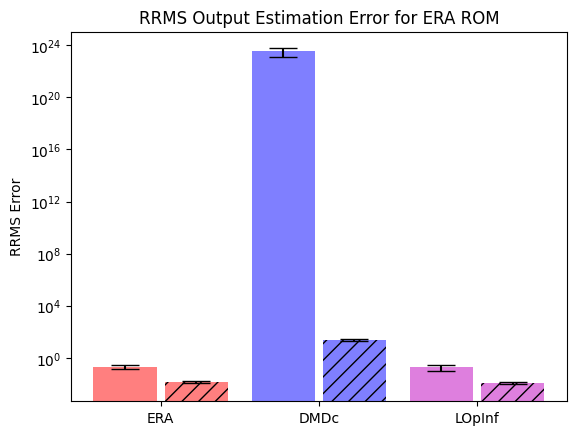

In [69]:
# Bar plot with error bars of open loop and closed loop RMS output errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

ax.bar(np.arange(0,6,2)-0.45, [np.mean(rms_era[0,:]), np.mean(rms_dmdc[0,:]), np.mean(rms_lopInf[0,:])], yerr=[np.std(rms_era[0,:]), np.std(rms_dmdc[0,:]), np.std(rms_lopInf[0,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,6,2)+0.45, [np.mean(rms_era[1,:]), np.mean(rms_dmdc[1,:]), np.mean(rms_lopInf[1,:])], yerr=[np.std(rms_era[1,:]), np.std(rms_dmdc[1,:]), np.std(rms_lopInf[1,:])], color=['r','b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')
# # Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,6,2)-0.45, [np.max(rms_era[0,:]), np.max(rms_dmdc[0,:]), np.max(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)-0.45, [np.min(rms_era[0,:]), np.min(rms_dmdc[0,:]), np.min(rms_lopInf[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.max(rms_era[1,:]), np.max(rms_dmdc[1,:]), np.max(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,6,2)+0.45, [np.min(rms_era[1,:]), np.min(rms_dmdc[1,:]), np.min(rms_lopInf[1,:])], 'k_', markersize=10, markeredgewidth=3)



ax.set_xticks(np.arange(0,6,2))
ax.set_xticklabels(['ERA','DMDc','LOpInf'])
ax.set_yticks([0,1,2])


ax.set_ylabel("RRMS Error")
ax.set_title("RRMS Output Estimation Error for ERA ROM")
# TODO: Fix legend

# Set legend where solid box is open loop and hatched box is closed loop
# ax.legend(['Max','Min','Open Loop','Closed Loop'],loc='upper left')
# Change to log scale y axis
ax.set_yscale('log')


# Save as svg
plt.savefig('RMSOutputEstimation.pdf', format='pdf', dpi=1200)

In [70]:
# Reconstruct full order states for DMDc and LOpInf using the basis transformations for every trial in the open and closed loop cases
# Initialize arrays to store reconstructed states
# DMDc
x_hat_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
x_hat_ol_dmdc_full = da.zeros((basis_dmdc.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
# LOpinf
x_hat_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))
x_hat_ol_lopInf_full = da.zeros((basis_lopinf.shape[0], timesteps, numTrials), chunks=(10000, timesteps, 1))

# For each timestep of each trial, reconstruct the full order state using the basis transformation
for trial in range(numTrials):
    x_hat_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_dmdc[:,:,trial]
    x_hat_ol_dmdc_full[:,:,trial] = basis_dmdc @ x_hat_ol_dmdc[:,:,trial]
    x_hat_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_lopInf[:,:,trial]
    x_hat_ol_lopInf_full[:,:,trial] = basis_lopinf @ x_hat_ol_lopInf[:,:,trial]

In [71]:
# del data

In [72]:
# Read in full state data from  as dask array
stateData = da.from_array(data['stateData'], chunks=(10000, timesteps, 1))
# Center state data for each trial
for trial in range(numTrials):
    stateData[:,:,trial] = stateData[:,:,trial] - stateData[:,0,trial].reshape(-1,1)

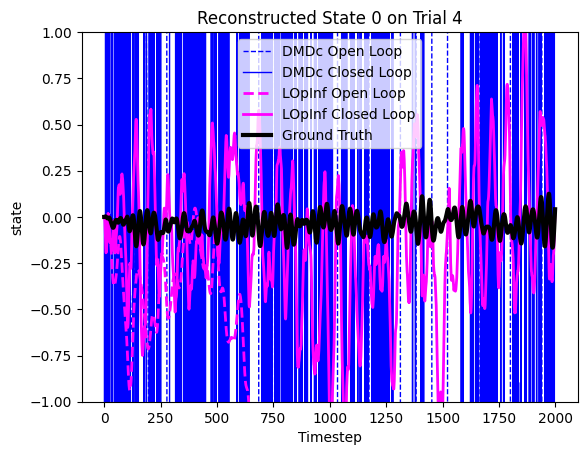

In [73]:
# Plot results for a specific trial with open loop responses in dashed lines and closed loop responses in solid lines and ground truth in black
trial = 4
plt.figure()
plt.plot(x_hat_ol_dmdc_full[0,:,trial].compute(), "--", label="DMDc Open Loop", color="blue", linewidth=1)
plt.plot(x_hat_dmdc_full[0,:,trial].compute(), label="DMDc Closed Loop", color="blue", linewidth=1)
plt.plot(x_hat_ol_lopInf_full[0,:,trial].compute(), "--", label="LOpInf Open Loop", color="magenta", linewidth=2)
plt.plot(x_hat_lopInf_full[0,:,trial].compute(), label="LOpInf Closed Loop", color="magenta", linewidth=2)
plt.plot(stateData[0,:,trial].compute(), label="Ground Truth", color="black", linewidth=3)

plt.xlabel("Timestep")
plt.ylabel("state")
plt.ylim([-1, 1])
plt.title("Reconstructed State 0 on Trial " + str(trial))
plt.legend()
# plt.show()



In [74]:
# Compute open and closed loop RRMS state errors for each method in each trial
# Initialize arrays to store open loop and closed loop RMS errors
rms_dmdc_full = da.zeros((2, numTrials)) # DMDc
rms_lopInf_full = da.zeros((2, numTrials)) # LOpInf
# Iterate through each trial
for trial in range(numTrials):
    # Compute open loop RMS error
    rms_dmdc_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_dmdc_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    rms_lopInf_full[0,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_ol_lopInf_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    # Compute closed loop RMS error
    rms_dmdc_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_dmdc_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))
    rms_lopInf_full[1,trial] = da.sqrt(da.mean(da.square(stateData[:,:,trial] - x_hat_lopInf_full[:,:,trial]))/da.linalg.norm(stateData[:,:,trial], ord='fro'))


In [75]:
# Execute dask arrays 
rms_dmdc_full, rms_lopInf_full = da.compute(rms_dmdc_full, rms_lopInf_full)


In [76]:
# Make table of mean +/- standard deviation, max, and min of RMS errors for each method
# Initialize table
rms_table = PrettyTable()
rms_table.field_names = ["Method", "Mean +/- Std Dev", "Max", "Min"]
# Add rows to table
rms_table.add_row(["DMDc Open Loop", str(np.mean(rms_dmdc_full[0,:])) + " +/- " + str(np.std(rms_dmdc_full[0,:])), str(np.max(rms_dmdc_full[0,:])) + " in trial " + str(np.argmax(rms_dmdc_full[0,:])), str(np.min(rms_dmdc_full[0,:])) + " in trial " + str(np.argmin(rms_dmdc_full[0,:]))])
rms_table.add_row(["DMDc Closed Loop", str(np.mean(rms_dmdc_full[1,:])) + " +/- " + str(np.std(rms_dmdc_full[1,:])), str(np.max(rms_dmdc_full[1,:])) + " in trial " + str(np.argmax(rms_dmdc_full[1,:])), str(np.min(rms_dmdc_full[1,:])) + " in trial " + str(np.argmin(rms_dmdc_full[1,:]))])
rms_table.add_row(["LOpInf Open Loop", str(np.mean(rms_lopInf_full[0,:])) + " +/- " + str(np.std(rms_lopInf_full[0,:])), str(np.max(rms_lopInf_full[0,:])) + " in trial " + str(np.argmax(rms_lopInf_full[0,:])), str(np.min(rms_lopInf_full[0,:])) + " in trial " + str(np.argmin(rms_lopInf_full[0,:]))])
rms_table.add_row(["LOpInf Closed Loop", str(np.mean(rms_lopInf_full[1,:])) + " +/- " + str(np.std(rms_lopInf_full[1,:])), str(np.max(rms_lopInf_full[1,:])) + " in trial " + str(np.argmax(rms_lopInf_full[1,:])), str(np.min(rms_lopInf_full[1,:])) + " in trial " + str(np.argmin(rms_lopInf_full[1,:]))])
# Print table
print(rms_table)

+--------------------+-------------------------------------------------+----------------------------------+-----------------------------------+
|       Method       |                 Mean +/- Std Dev                |               Max                |                Min                |
+--------------------+-------------------------------------------------+----------------------------------+-----------------------------------+
|   DMDc Open Loop   | 2.598638407798296e+19 +/- 2.015503525003142e+19 | 7.072621434502234e+19 in trial 0 | 4.2959605799694167e+18 in trial 9 |
|  DMDc Closed Loop  |     5.680491111437466 +/- 0.5236251709071135    |   6.694998683191203 in trial 1   |    4.651457790474398 in trial 5   |
|  LOpInf Open Loop  |  0.020251934129547323 +/- 0.009327292865551149  | 0.040873938842232074 in trial 8  |  0.007666889204709553 in trial 0  |
| LOpInf Closed Loop |  0.004778314484420194 +/- 0.000899216515658314  | 0.006043670997956407 in trial 9  |  0.003485014344119586 in tri

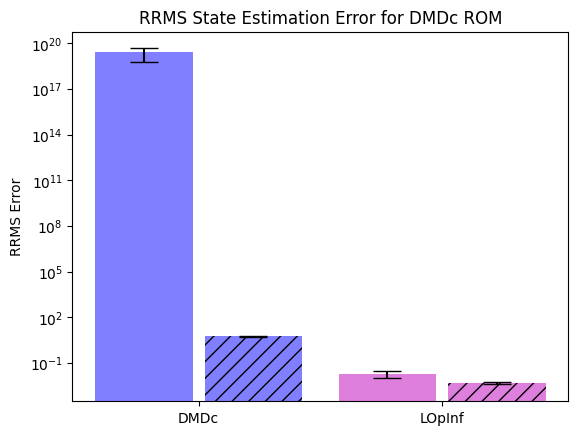

In [77]:
# Bar plot with error bars of open loop and closed loop RMS state errors for each method where open loop and closed loop responses are adjacent
fig, ax = plt.subplots()

# ax.figure(figsize=(10,5))
ax.bar(np.arange(0,4,2)-0.45, [np.mean(rms_dmdc_full[0,:]), np.mean(rms_lopInf_full[0,:])], yerr=[np.std(rms_dmdc_full[0,:]), np.std(rms_lopInf_full[0,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10)
ax.bar(np.arange(0,4,2)+0.45, [np.mean(rms_dmdc_full[1,:]), np.mean(rms_lopInf_full[1,:])], yerr=[np.std(rms_dmdc_full[1,:]), np.std(rms_lopInf_full[1,:])], color=['b','m'],align='center',alpha=0.5,ecolor='black',capsize=10,hatch='//')

# Plot max and min of each method overlayed on bars
# ax.plot(np.arange(0,4,2)-0.45, [np.max(rms_dmdc_full[0,:]), np.max(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)-0.45, [np.min(rms_dmdc_full[0,:]), np.min(rms_lopInf_full[0,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.max(rms_dmdc_full[1,:]), np.max(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)
# ax.plot(np.arange(0,4,2)+0.45, [np.min(rms_dmdc_full[1,:]), np.min(rms_lopInf_full[1,:])], 'k_', markersize=10, markeredgewidth=3)

# Change to log scale y axis
ax.set_yscale('log')

ax.set_xticks(np.arange(0,4,2))
ax.set_xticklabels(['DMDc','LOpInf'])
# ax.set_yticks([1e0,1e1,1e2])



ax.set_ylabel("RRMS Error")
ax.set_title("RRMS State Estimation Error for DMDc ROM")
# Make legend where hatched boxes correspond to closed loop responses and solid boxes correspond to open loop responses

# Save as svg
plt.savefig('stateObserverAnalysis.pdf', format='pdf', dpi=1200)


# Prediction Horizon Experiments

In [89]:
rrms_dmdc_horizon_avg.shape

(2000,)

In [176]:
# Compute output RRMSE for each method as a function of prediction horizon

# Read in the data set
U_fom = data["inputData"][:,:,n_train:n_test+n_train]
Y_fom = data["reducedCenterlineData"][:,:,n_train:n_test+n_train]
# subtract initial condition from Y_fom for each trial
for i in range(Y_fom.shape[2]):
    Y_fom[:,:,i] = Y_fom[:,:,i] - Y_fom[:,0,i].reshape(-1,1)

# Initialize arrays to store state etimates and outputs for each method
# ERA
x_hat_era = np.zeros((A_era.shape[0], timesteps, n_test)) # Closed loop era observer
y_hat_era = np.zeros((C_era.shape[0], timesteps, n_test)) # Closed loop era observer
# DMDc
x_hat_dmdc = np.zeros((A_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
y_hat_dmdc = np.zeros((C_dmdc.shape[0], timesteps, n_test)) # Closed loop dmdc observer
# LOpinf
x_hat_lopInf = np.zeros((A_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer
y_hat_lopInf = np.zeros((C_lopInf.shape[0], timesteps, n_test)) # Closed loop lopinf observer

# Iterate through each trial
for trial in range(n_test):
    # Iterate through each timestep applying observer update law
    for i in range(timesteps-1):
        # Update observer states
        x_hat_era[:,i+1,trial] = A_era @ x_hat_era[:,i,trial] +B_era@U_fom[:,i,trial] # Open loop era observer
        x_hat_dmdc[:,i+1,trial] = A_dmdc @ x_hat_dmdc[:,i,trial] +B_dmdc@U_fom[:,i,trial] # Open loop dmdc observer
        x_hat_lopInf[:,i+1,trial] = A_lopInf @ x_hat_lopInf[:,i,trial] +B_lopInf@U_fom[:,i,trial] # Open loop lopinf observer

        # Update observer output
        y_hat_era[:,i+1,trial] = C_era @ x_hat_era[:,i+1,trial] + D_era @ U_fom[:,i,trial] # Closed loop era observer
        y_hat_dmdc[:,i+1,trial] = C_dmdc @ x_hat_dmdc[:,i+1,trial] # Closed loop dmdc observer
        y_hat_lopInf[:,i+1,trial] = C_lopInf @ x_hat_lopInf[:,i+1,trial] # Closed loop lopinf observer
        
### Compute RRMSE and standard deviation of RRMSE for each method ### 
# Initialize arrays to store open loop and closed loop RMS errors
rms_era = np.zeros((n_test)) # ERA
rms_dmdc = np.zeros((n_test)) # DMDc
rms_lopInf = np.zeros((n_test)) # LOpInf
# Compute error vectors
error_era_mag = np.linalg.norm((Y_fom - y_hat_era),ord=2,axis=0)
error_dmdc_mag = np.linalg.norm((Y_fom - y_hat_dmdc),ord=2,axis=0)
error_lopInf_mag = np.linalg.norm((Y_fom - y_hat_lopInf),ord=2,axis=0)
# Compute magnitude of deflection
Y_fom_mag = np.linalg.norm(Y_fom,ord=2,axis=0)

# relative errors
rel_error_era = error_era_mag/Y_fom_mag
rel_error_dmdc = error_dmdc_mag/Y_fom_mag
rel_error_lopInf = error_lopInf_mag/Y_fom_mag

# average relative errors
rel_error_era_avg = np.mean(rel_error_era,axis=1)
rel_error_dmdc_avg = np.mean(rel_error_dmdc,axis=1)
rel_error_lopInf_avg = np.mean(rel_error_lopInf,axis=1)
# standard deviation of relative errors
rel_error_era_std = np.std(rel_error_era,axis=1)
rel_error_dmdc_std = np.std(rel_error_dmdc,axis=1)
rel_error_lopInf_std = np.std(rel_error_lopInf,axis=1)

# Average deflection magnitude
Y_fom_mag_avg = np.mean(Y_fom_mag,axis=1)
# standard deviation of deflection magnitude
Y_fom_mag_std = np.std(Y_fom_mag,axis=1)


Text(0.5, 0, 'Prediction Horizon')

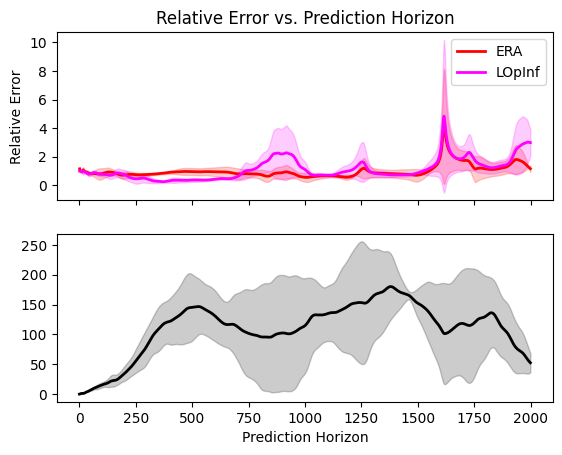

In [177]:
# Make figure with 2 vertically stacked subplots
fig, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
# In the top subplot plot average relative errors and standard deviation of relative errors for each method as a function of prediction horizon with standard deviations as colored regions
ax1.plot(np.arange(0,timesteps), rel_error_era_avg, label="ERA", color="red", linewidth=2)
ax1.fill_between(np.arange(0,timesteps), rel_error_era_avg - rel_error_era_std, rel_error_era_avg + rel_error_era_std, color="red", alpha=0.2)
# ax1.plot(np.arange(0,timesteps), rel_error_dmdc_avg, label="DMDc", color="blue", linewidth=2)
# ax1.fill_between(np.arange(0,timesteps), rel_error_dmdc_avg - rel_error_dmdc_std, rel_error_dmdc_avg + rel_error_dmdc_std, color="blue", alpha=0.2)
ax1.plot(np.arange(0,timesteps), rel_error_lopInf_avg, label="LOpInf", color="magenta", linewidth=2)
ax1.fill_between(np.arange(0,timesteps), rel_error_lopInf_avg - rel_error_lopInf_std, rel_error_lopInf_avg + rel_error_lopInf_std, color="magenta", alpha=0.2)
# ax1.set_xlabel("Prediction Horizon")
ax1.set_ylabel("Relative Error")
ax1.set_title("Relative Error vs. Prediction Horizon")
ax1.legend()

# Bottom plot - average deflection magnitude and standard deviation of deflection magnitude for each method as a function of prediction horizon with standard deviations as colored regions
ax2.plot(np.arange(0,timesteps), Y_fom_mag_avg, label="Ground Truth", color="black", linewidth=2)
ax2.fill_between(np.arange(0,timesteps), Y_fom_mag_avg - Y_fom_mag_std, Y_fom_mag_avg + Y_fom_mag_std, color="black", alpha=0.2)
ax2.set_xlabel("Prediction Horizon")

# ax.set_ylim([-5, 5])
# # Save as svg
# plt.savefig("relativeErrorVsHorizon.pdf", format="pdf", dpi=1200)


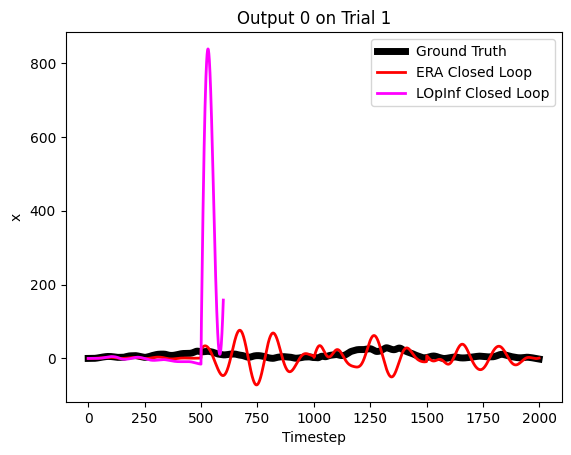

In [157]:
trial = 1
fig, ax = plt.subplots()


# plt.figure()
ax.plot(Y_fom[0,:,trial], label="Ground Truth", color="black", linewidth=5)
ax.plot(y_hat_era[0,:,trial], label="ERA Closed Loop", color="red", linewidth=2)
# ax.plot(y_hat_ol_dmdc[0,:,trial], "--", label="DMDc Open Loop", color="blue", linewidth=5)
# ax.plot(y_hat_dmdc[0,:,trial], label="DMDc Closed Loop", color="blue", linewidth=5)
# plt.plot(y_hat_ol_opInf[0,:,trial], "--", label="OpInf Open Loop", color="green", linewidth=5)
# plt.plot(y_hat_opInf[0,:,trial], label="OpInf Closed Loop", color="green", linewidth=5)
ax.plot(y_hat_lopInf[0,0:600,trial], label="LOpInf Closed Loop", color="magenta", linewidth=2)
ax.set_xlabel("Timestep")
ax.set_ylabel("x")
ax.set_title("Output 0 on Trial " + str(trial))
ax.legend()
# Save as svg
# plt.savefig("output0_trial" + str(trial) + ".pdf", format="pdf")

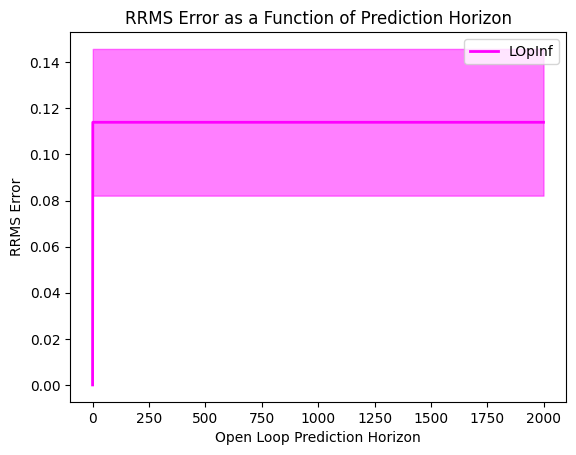

In [82]:
# Plot RRMS error as a function of prediction horizon with standard deviation as colored region around mean
plt.figure()
# plt.plot(rrms_era[0,:], label="ERA", color="red", linewidth=3)
# plt.fill_between(np.arange(0,timesteps), rrms_era[0,:] - rrms_era[1,:], rrms_era[0,:] + rrms_era[1,:], color="red", alpha=0.5)
# plt.plot(rrms_dmdc_horizon_avg, label="DMDc", color="blue", linewidth=1)
# plt.fill_between(np.arange(0,timesteps), rrms_dmdc_horizon_avg - rrms_dmdc_horizon_std, rrms_dmdc_horizon_avg + rrms_dmdc_horizon_std, color="blue", alpha=0.5)
plt.plot(rrms_lopInf_horizon_avg, label="LOpInf", color="magenta", linewidth=2)
plt.fill_between(np.arange(0,timesteps), rrms_lopInf_horizon_avg - rrms_lopInf_horizon_std, rrms_lopInf_horizon_avg + rrms_lopInf_horizon_std, color="magenta", alpha=0.5)
plt.xlabel("Open Loop Prediction Horizon")
plt.ylabel("RRMS Error")
plt.title("RRMS Error as a Function of Prediction Horizon")
plt.legend()
plt.show()

